Kloniranje git repozitorija

In [1]:
!git clone https://github.com/mirna-k/dcp-miniBRANCH.git
%cd dcp-miniBRANCH


Cloning into 'dcp-miniBRANCH'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 31 (delta 7), reused 8 (delta 5), pack-reused 16 (from 1)
Receiving objects: 100% (31/31), 16.93 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/dcp-miniBRANCH


Ucitavanje ZIPa sa slikama drveca

In [2]:
from google.colab import files
uploaded = files.upload()


Saving miniBRANCH-20250531T113842Z-1-001.zip to miniBRANCH-20250531T113842Z-1-001.zip


Raspakirati ZIP file

In [3]:
import zipfile
import os

zip_filename = list(uploaded.keys())[0]

# Raspakiraj u novu mapu
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("miniBRANCH_data")

# Prikaži što se nalazi unutar
!ls miniBRANCH_data


miniBRANCH


In [4]:
# Prikazujemo sve mape unutar raspakiranog foldera
!ls miniBRANCH_data/miniBRANCH


tree_1_V_0001  tree_1_V_0009  tree_1_V_0011  tree_1_V_0012


Ucitavanje podataka u miniBRANCH

In [5]:
from data import miniBRANCH

# Povezujemo na RGB i depth direktorije jednog stabla
dataset = miniBRANCH(
    rgb_dir='miniBRANCH_data/miniBRANCH/tree_1_V_0001/Filtered__noGrass/color',
    depth_dir='miniBRANCH_data/miniBRANCH/tree_1_V_0001/Filtered__noGrass/depth',
    num_points=1024,
    partition='train'
)

# Test: učitaj prvi par oblaka točaka
sample = dataset[0]
pointcloud1, pointcloud2 = sample[0], sample[1]

print("Oblik točaka - pointcloud1:", pointcloud1.shape)
print("Oblik točaka - pointcloud2:", pointcloud2.shape)


Oblik točaka - pointcloud1: (3, 1024)
Oblik točaka - pointcloud2: (3, 1024)


Treniranje modela

In [9]:
from model import DCP
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch

# 1. Dataset i DataLoader
train_dataset = miniBRANCH(
    rgb_dir='miniBRANCH_data/miniBRANCH/tree_1_V_0001/Filtered__noGrass/color',
    depth_dir='miniBRANCH_data/miniBRANCH/tree_1_V_0001/Filtered__noGrass/depth',
    num_points=1024,
    partition='train'
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 2. Model
class Args:
    emb_dims = 512
    emb_nn = 'pointnet'
    pointer = 'transformer'
    head = 'svd'
    n_blocks = 1
    n_heads = 4
    ff_dims = 1024
    dropout = 0.0
    cycle = False

args = Args()
model = DCP(args).cuda()

# 3. Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


loss_history = []


# 4. Petlja za treniranje
for epoch in range(50):
    model.train()
    total_loss = 0

    for batch in train_loader:
        src, tgt, R_gt, t_gt, _, _, _, _ = batch
        src = src.cuda()
        tgt = tgt.cuda()
        R_gt = R_gt.cuda()
        t_gt = t_gt.cuda()

        optimizer.zero_grad()
        R_pred, t_pred, _, _ = model(src, tgt)

        identity = torch.eye(3).to(src.device).unsqueeze(0).repeat(src.size(0), 1, 1)
        loss_r = F.mse_loss(torch.matmul(R_pred.transpose(2,1), R_gt), identity)
        loss_t = F.mse_loss(t_pred, t_gt)
        loss = loss_r + loss_t

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_history.append(total_loss)

    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")


[Epoch 1] Loss: 7337.7834
[Epoch 2] Loss: 2444.5350
[Epoch 3] Loss: 1836.0922
[Epoch 4] Loss: 227.9615
[Epoch 5] Loss: 930.1016
[Epoch 6] Loss: 177.7706
[Epoch 7] Loss: 124.6158
[Epoch 8] Loss: 186.4269
[Epoch 9] Loss: 354.6655
[Epoch 10] Loss: 566.6903
[Epoch 11] Loss: 308.2832
[Epoch 12] Loss: 89.4178
[Epoch 13] Loss: 338.4357
[Epoch 14] Loss: 203.2636
[Epoch 15] Loss: 202.0172
[Epoch 16] Loss: 268.1059
[Epoch 17] Loss: 276.2194
[Epoch 18] Loss: 184.3705
[Epoch 19] Loss: 90.0378
[Epoch 20] Loss: 157.1954
[Epoch 21] Loss: 114.2567
[Epoch 22] Loss: 55.9728
[Epoch 23] Loss: 162.1809
[Epoch 24] Loss: 221.7383
[Epoch 25] Loss: 177.0547
[Epoch 26] Loss: 104.4664
[Epoch 27] Loss: 162.4659
[Epoch 28] Loss: 106.7696
[Epoch 29] Loss: 165.8851
[Epoch 30] Loss: 117.8014
[Epoch 31] Loss: 111.6477
[Epoch 32] Loss: 293.3489
[Epoch 33] Loss: 74.6469
[Epoch 34] Loss: 150.9941
[Epoch 35] Loss: 107.5249
[Epoch 36] Loss: 221.5693
[Epoch 37] Loss: 407.8184
[Epoch 38] Loss: 183.9580
[Epoch 39] Loss: 127.2

In [11]:
torch.save(model.state_dict(), "dcp_model.pth")


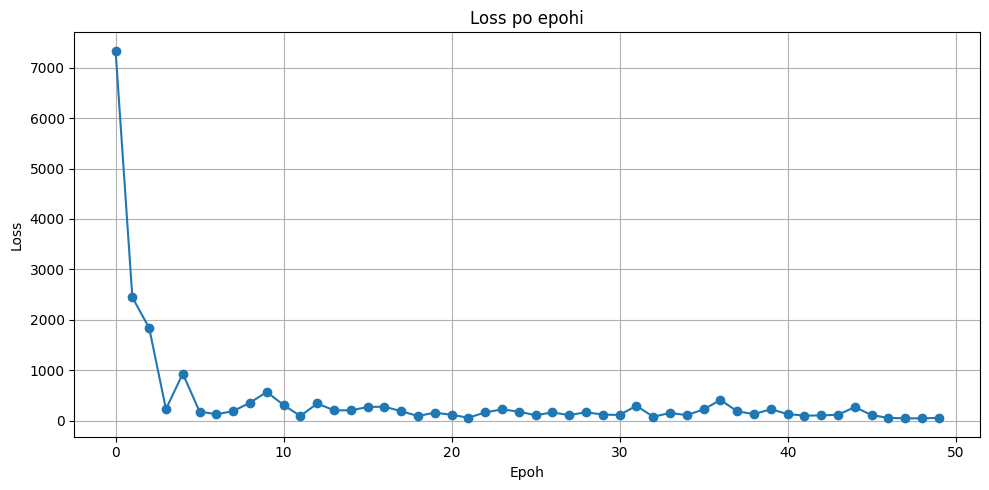

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o')
plt.title('Loss po epohi')
plt.xlabel('Epoh')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
plt.savefig("loss_graph.png")


<Figure size 640x480 with 0 Axes>